# <span style="color:Red">Modelos Tradicionales</span>

In [1]:
import numpy as np
import pandas as pd
import random
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import statsmodels.api as sm
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
from pypfopt import expected_returns
from scipy.linalg import inv
from scipy.optimize import minimize
import cvxpy as cp
import function.F_Datos as FDatos
import function.F_FamaFactors as gff
import warnings
warnings.filterwarnings("ignore")



In [2]:
#Tickers a analizar
tickers = [
    "AAPL",
    "DIS",
    "MSFT",
    "AMZN",
    "GOOG",
]

In [3]:
START_DATE = "2016-01-01"
END_DATE   = "2024-12-31"

tickers_orig_df = FDatos.load_ticker_prices_ts_df(tickers, START_DATE, END_DATE)
retornos        = tickers_orig_df.dropna(axis=1).pct_change().dropna()  # first % is NaN

In [4]:
retornos.head()

,AAPL,DIS,MSFT,AMZN,GOOG
2016-01-05 00:00:00,-0.025059,-0.020198,0.004562,-0.005024,0.000998
2016-01-06 00:00:00,-0.019570,-0.005352,-0.018165,-0.001799,0.001400
2016-01-07 00:00:00,-0.042205,-0.008569,-0.034783,-0.039058,-0.023170
2016-01-08 00:00:00,0.005288,-0.002512,0.003067,-0.001464,-0.016410
2016-01-11 00:00:00,0.016192,0.006751,-0.000574,0.017610,0.002183


In [5]:
retornos.to_csv("data/retornosYF.csv")

## <span style="color:whithe">Markowitz</span>


In [6]:
def utility_fn(x, a=0.15, b=0.1, c=1):
    return a * x**2 + b * x + c

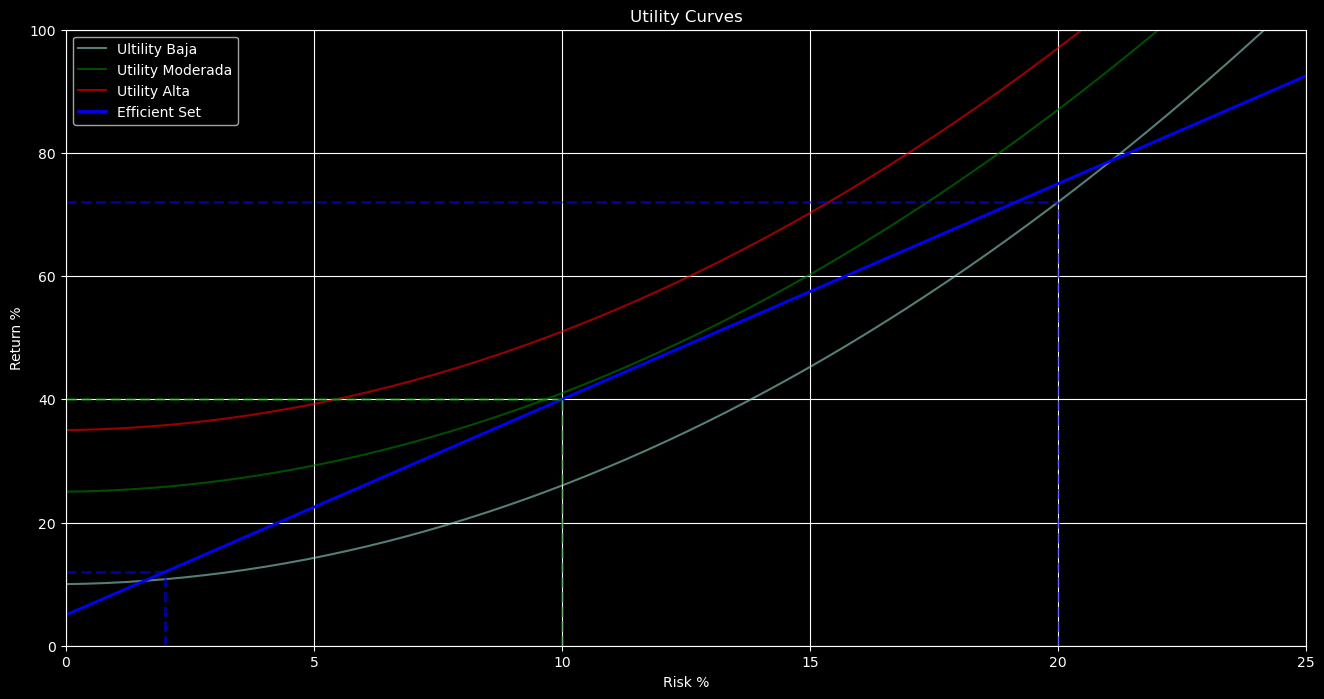

In [9]:
plt.style.use('dark_background')
plt.figure(figsize=(16, 8)) 

x_values_1 = np.linspace(0, 40, 100) 
y_values_1 = utility_fn(x_values_1, c=10)
plt.plot(x_values_1, y_values_1, label="Ultility Baja", alpha=0.6)

x_values_2 = np.linspace(0, 35, 100)
y_values_2 = utility_fn(x_values_2, c=25)
plt.plot(x_values_2, y_values_2, label="Utility Moderada", color="g", alpha=0.6)

x_values_3 = np.linspace(0, 30, 100)
y_values_3 = utility_fn(x_values_3, c=35)
plt.plot(x_values_3, y_values_3, label="Utility Alta", color="r", alpha=0.6)

plt.plot([0, 40], [5, 145], label="Efficient Set", color="b", linewidth=2)
plt.plot([2, 2], [0, 12], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([0, 2], [12, 12], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([10, 10], [0, 40], linestyle="--", color="g", alpha=0.6, linewidth=2)
plt.plot([0, 10], [40, 40], linestyle="--", color="g", alpha=0.6, linewidth=2)
plt.plot([20, 20], [0, 72], linestyle="--", color="b", alpha=0.6, linewidth=2)
plt.plot([0, 20], [72, 72], linestyle="--", color="b", alpha=0.6, linewidth=2)

plt.xlabel("Risk %", color='white')
plt.ylabel("Return %", color='white')
plt.title("Utility Curves", color='white')
plt.legend()
plt.grid()
plt.xlim(0, 25)
plt.ylim(0, 100)
plt.show()

In [10]:
TRADING_DAYS_IN_YEAR = 252 
RISK_FREE_RATE       = 0.05 
MAX_PORTS            = 10000 
MAX_WEIGHT           = 1 

In [11]:
rets       = ((1 + retornos).prod() ** (TRADING_DAYS_IN_YEAR / len(retornos))) - 1
cov_matrix = retornos.cov() * TRADING_DAYS_IN_YEAR

In [12]:
def port_generator(rets, cov_matrix):

    port_rets = []
    port_risks = []
    port_sharpes = []
    port_weights = []

    for _ in range(MAX_PORTS):
        
        weights = np.random.uniform(-MAX_WEIGHT, MAX_WEIGHT, len(rets)) 
        weights /= np.sum(weights)  
        if any(weights > MAX_WEIGHT):
            continue
        port_weights.append(weights)

        port_ret = np.dot(weights, rets)
        port_rets.append(port_ret)

        port_risk = np.sqrt(weights.T @ cov_matrix @ weights)
        port_risks.append(port_risk)

        port_sharpe = (port_ret - RISK_FREE_RATE) / port_risk
        port_sharpes.append(port_sharpe)

    port_rets = np.array(port_rets)
    port_risks = np.array(port_risks)

    plt.scatter(
        port_risks * 100.0,
        port_rets * 100.0,
        c=port_sharpes,
        cmap="viridis",
        alpha=0.75,
    )

    plt.xlabel("Risk (%)")
    plt.ylabel("E(r) (%)")
    plt.colorbar(label="Ratio de Sharpe")
    plt.grid()

    return port_risks, port_rets, port_sharpes

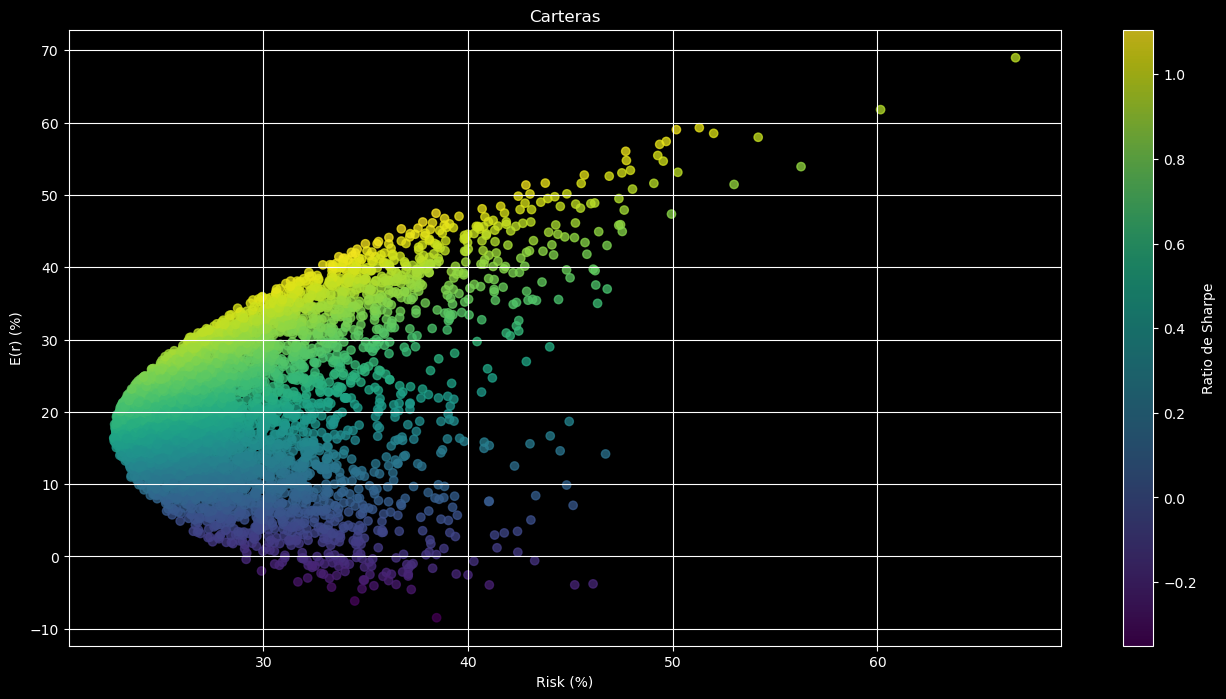

In [14]:
plt.style.use('dark_background')

plt.figure(figsize=(16, 8))
plt.title("Carteras", color='white')
port_risks, port_rets, port_sharpes = port_generator(rets, cov_matrix)
plt.show()

### <span style="color:white">Construcción de los BenchMarks</span>

In [15]:
equal_weights = np.ones(len(rets))
rets = ((1 + retornos).prod() ** (TRADING_DAYS_IN_YEAR / len(retornos))) - 1
cov_matrix = retornos.cov() * TRADING_DAYS_IN_YEAR
inv_cov_matrix  = np.linalg.pinv(cov_matrix)
min_risk_vect   = equal_weights @ inv_cov_matrix 
expect_ret_vect = inv_cov_matrix @ rets

mvp_weights = min_risk_vect / np.sum(min_risk_vect)
mvp_ret = mvp_weights @ rets
mvp_risk = np.sqrt(mvp_weights.T @ cov_matrix @ mvp_weights)

tan_weights = expect_ret_vect / np.sum(expect_ret_vect)
tan_ret = tan_weights @ rets
tan_risk = np.sqrt(tan_weights.T @ cov_matrix @ tan_weights)

summary_data = {
    "Activos": tickers,
    "MVP Pesos": mvp_weights,
    "TAN Pesos": tan_weights,
}

print(f"mvp_ret: {mvp_ret*100:0.02f}%, mvp_risk {mvp_risk*100:0.02f}%")
print(f"tan_ret: {tan_ret*100:0.02f}%, tan_risk {tan_risk*100:0.02f}%")

summary_df = pd.DataFrame(summary_data)
summary_df.T

mvp_ret: 16.94%, mvp_risk 22.68%
tan_ret: 46.64%, tan_risk 37.63%


,0,1,2,3,4
Activos,AAPL,DIS,MSFT,AMZN,GOOG
MVP Pesos,0.195068,0.373475,0.216185,0.051922,0.16335
TAN Pesos,0.849977,-0.61912,0.880141,0.059667,-0.170666


In [16]:
rf_rate = 0.05
mvp_sharpe = (mvp_ret - rf_rate) / mvp_risk
tan_sharpe = (tan_ret - rf_rate) / tan_risk

print(f"mvp_sharpe: {mvp_sharpe:0.02f}")
print(f"tan_sharpe: {tan_sharpe:0.02f}")


mvp_sharpe: 0.53
tan_sharpe: 1.11


In [17]:
MAX_RETS = 0.51
TEN_BASIS_POINTS = 0.0001 * 10


c = np.sum(equal_weights * min_risk_vect) 
b = np.sum(rets * min_risk_vect)  
a = np.sum(rets * expect_ret_vect)  

utility_func = (a * c) + (-(b**2))  


exp_rets = np.arange(0, MAX_RETS, TEN_BASIS_POINTS)
ports_risk_frontier = np.sqrt(
    ((c * (exp_rets**2)) - (2 * b * exp_rets) + a) / utility_func
)
mcl_vector = exp_rets * (1 / np.sqrt(a))

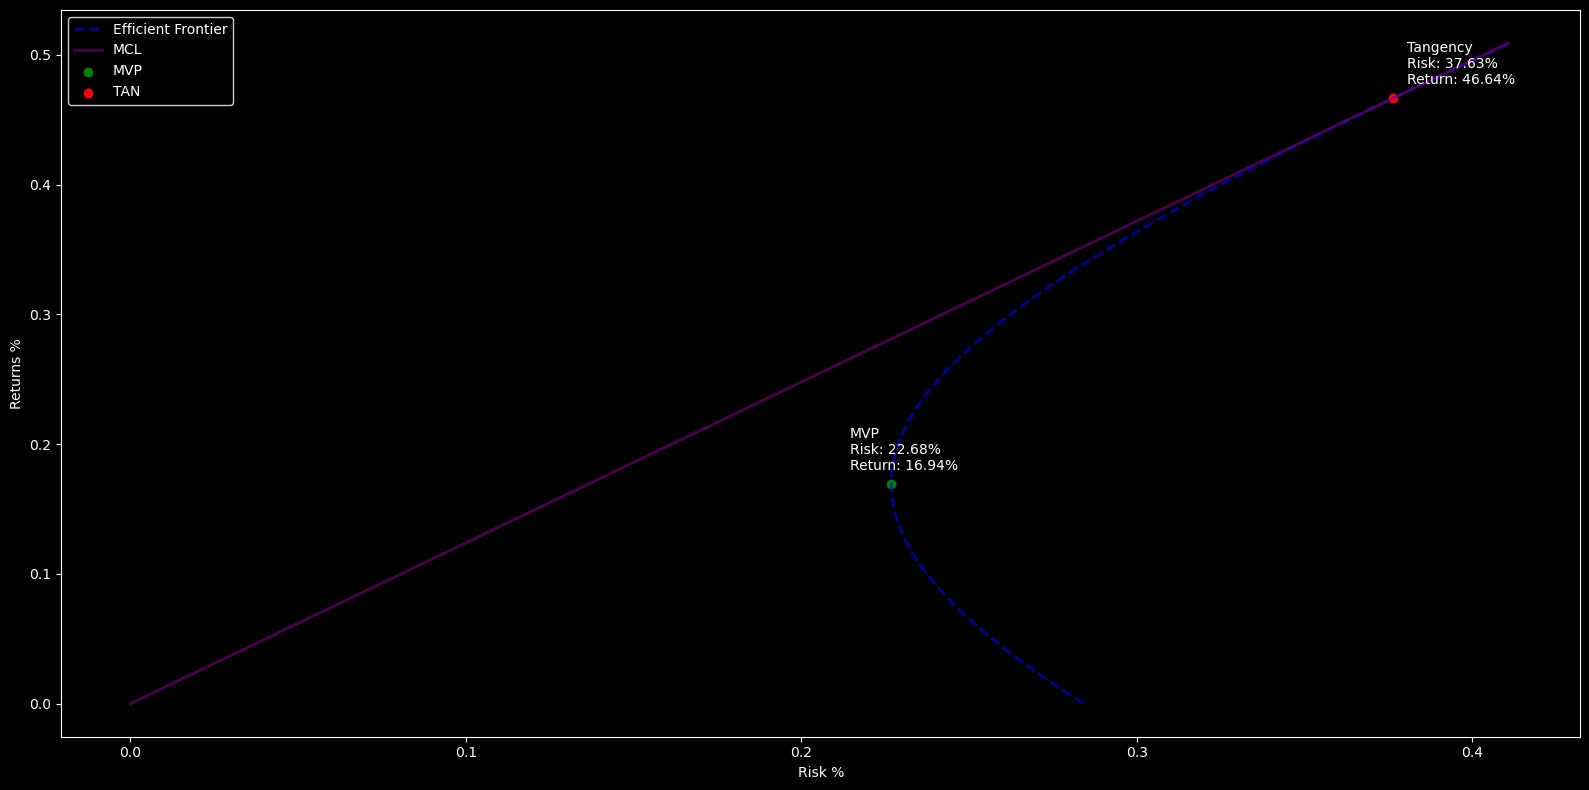

In [18]:
plt.style.use('dark_background')

plt.figure(figsize=(16, 8))
plt.plot(
    ports_risk_frontier,
    exp_rets,
    linestyle="--",
    color="blue",
    label="Efficient Frontier",
    linewidth=2,
    alpha=0.6,
)
plt.plot(
    mcl_vector,
    exp_rets,
    label="MCL",
    linewidth=2,
    alpha=0.6,
    color="Purple",
)

plt.scatter(mvp_risk, mvp_ret, color="green", label="MVP")
plt.annotate(
    f"MVP\nRisk: {mvp_risk*100:.2f}%\nReturn: {mvp_ret*100:.2f}%",
    (mvp_risk, mvp_ret),
    textcoords="offset points",
    xytext=(-30, 10),
    color='white'
)
plt.scatter(tan_risk, tan_ret, color="red", label="TAN")
plt.annotate(
    f"Tangency\nRisk: {tan_risk*100:.2f}%\nReturn: {tan_ret*100:.2f}%",
    (tan_risk, tan_ret),
    textcoords="offset points",
    xytext=(10, 10),
    color='white'
)

plt.legend(loc="upper left", fontsize=10, facecolor='black', edgecolor='white')
plt.xlabel("Risk %", color='white')
plt.ylabel("Returns %", color='white')
plt.tight_layout()

plt.show()

In [19]:
TARGET_RET = 0.3

pt_port  = None
opt_risk = None
opt_ret  = None

mvp_weights = (a - (b * TARGET_RET)) / utility_func
tan_weights = ((c * TARGET_RET) - b) / utility_func

opt_port_weights = (mvp_weights * min_risk_vect) + (tan_weights * expect_ret_vect)
opt_ret          = np.sum(opt_port_weights * rets)
opt_risk         = np.sqrt(((c * (opt_ret**2)) - (2 * b * opt_ret) + a) / utility_func)

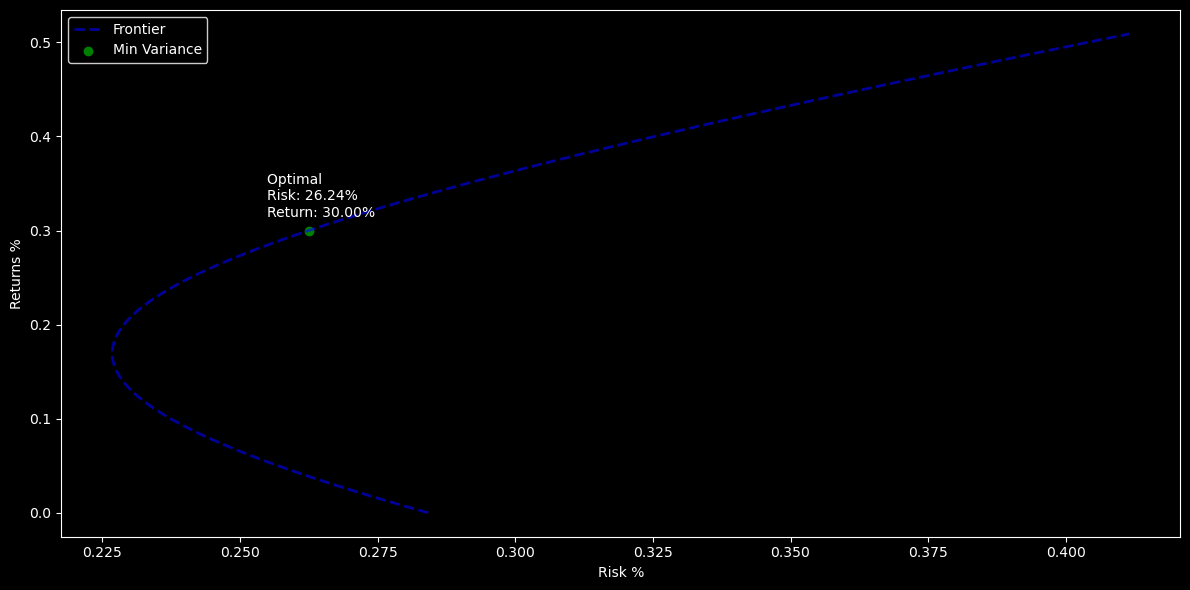

In [20]:
plt.style.use('dark_background')

plt.figure(figsize=(12, 6))
plt.plot(
    ports_risk_frontier,
    exp_rets,
    linestyle="--",
    color="blue",
    label="Frontier",
    linewidth=2,
    alpha=0.6,
)

plt.scatter(opt_risk, opt_ret, color="green", label="Min Variance")
plt.annotate(
    f"Optimal \nRisk: {opt_risk*100:.2f}%\nReturn: {opt_ret*100:.2f}%",
    (opt_risk, opt_ret),
    textcoords="offset points",
    xytext=(-30, 10),
    color='white'
)

plt.legend(loc="upper left", fontsize=10, facecolor='black', edgecolor='white')
plt.xlabel("Risk %", color='white')
plt.ylabel("Returns %", color='white')
plt.tight_layout()
plt.show()

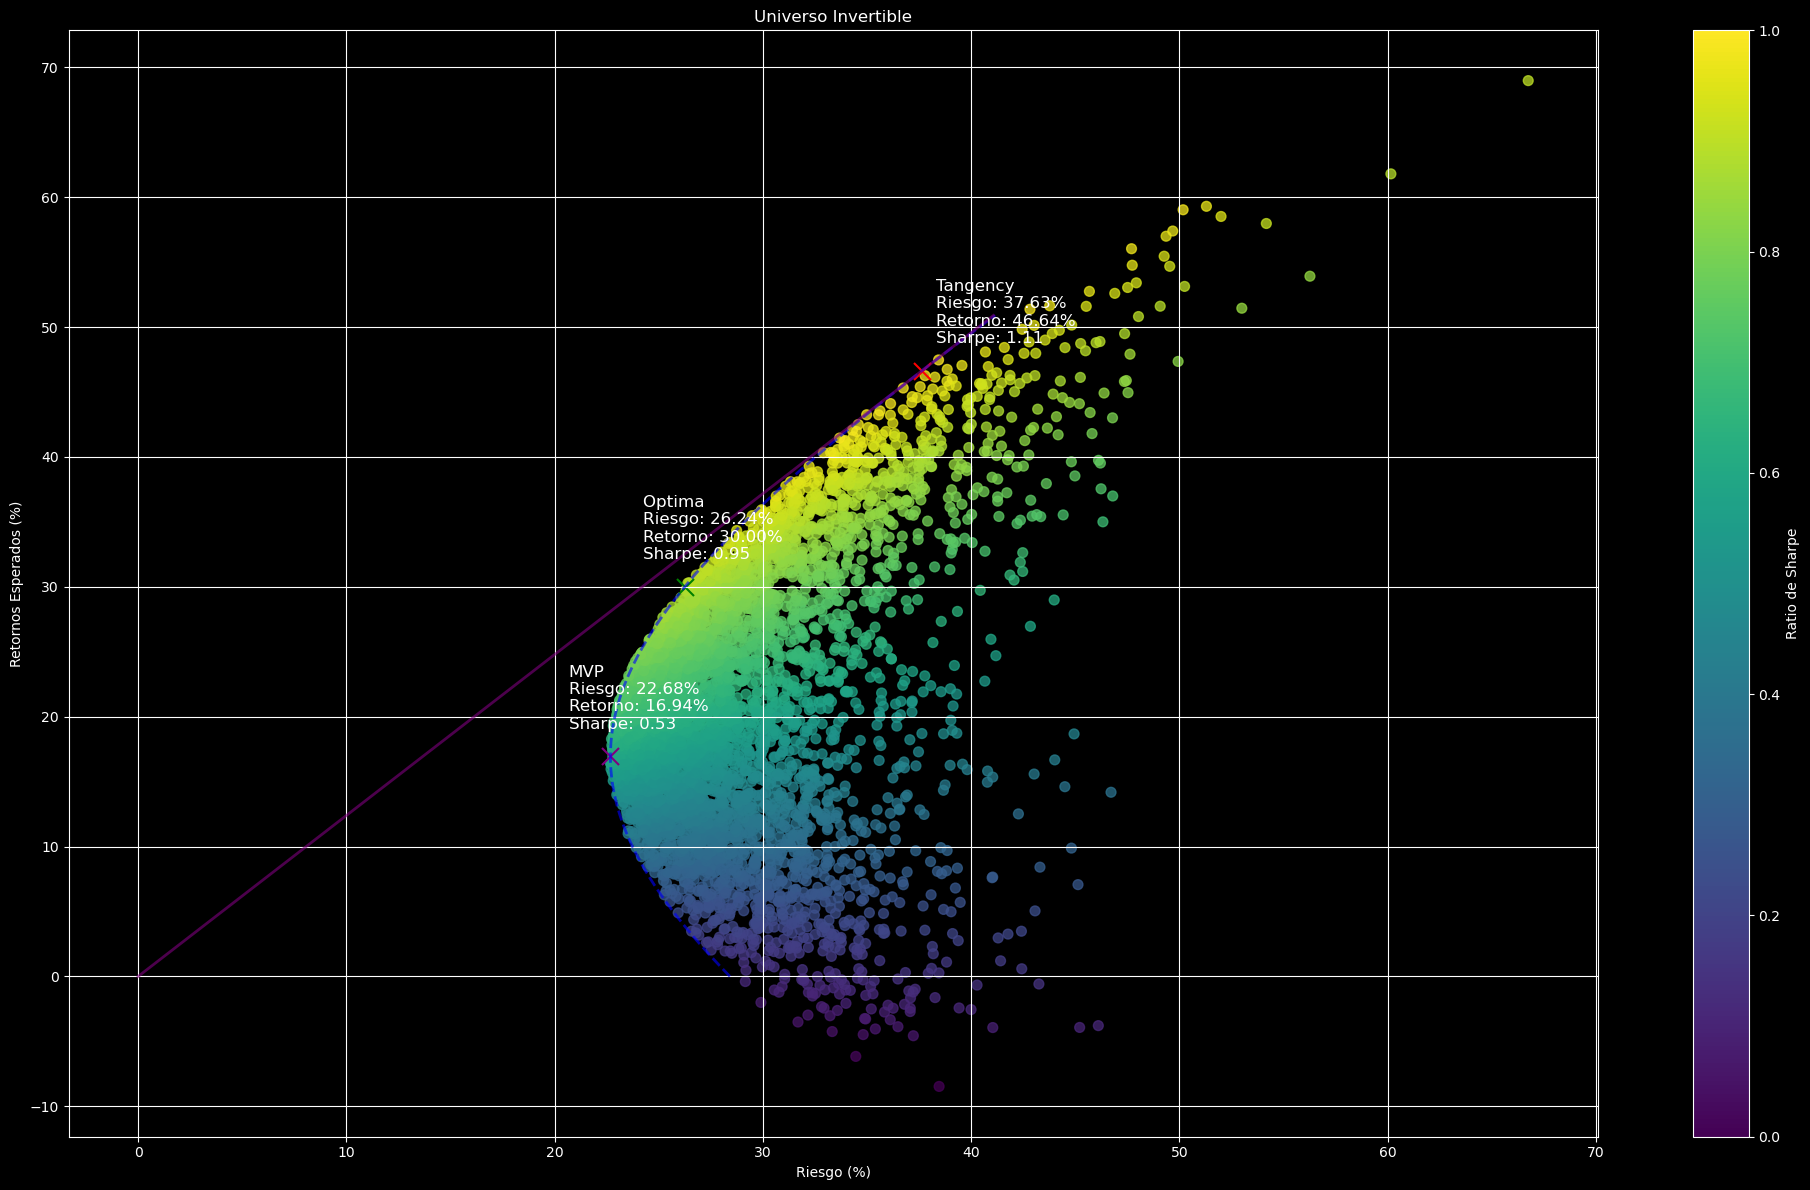

In [21]:
opt_sharpe = (opt_ret - RISK_FREE_RATE) / opt_risk
mvp_sharpe = (mvp_ret - RISK_FREE_RATE) / mvp_risk
tan_sharpe = (tan_ret - RISK_FREE_RATE) / tan_risk

plt.style.use('dark_background')

plt.figure(figsize=(20, 12)) 

plt.title("Universo Invertible", color='white')

plt.scatter(
    port_risks * 100.0,
    port_rets * 100.0,
    c=port_sharpes,
    cmap="viridis",
    alpha=0.75,
    s=50,  
)

plt.plot(
    ports_risk_frontier * 100,
    exp_rets * 100,
    linestyle="--",
    color="blue",
    label="Frontera",
    linewidth=2,
    alpha=0.6,
)

plt.scatter(
    opt_risk * 100,
    opt_ret * 100,
    color="green",
    marker="x",
    s=150,
    label="Optimal Expected Returns",
)
plt.annotate(
    f"Optima \nRiesgo: {opt_risk*100:.2f}%\nRetorno: {opt_ret*100:.2f}%\nSharpe: {opt_sharpe:.2f}",
    (opt_risk * 100, opt_ret * 100),
    textcoords="offset points",
    xytext=(-30, 20),  
    fontsize=12, 
    color='white'
)

plt.plot(
    mcl_vector * 100,
    exp_rets * 100,
    label="MCL",
    linewidth=2,
    alpha=0.6,
    color="Purple",
)


plt.scatter(
    mvp_risk * 100,
    mvp_ret * 100,
    color="Purple",
    label="MVP",
    marker="x",
    s=150,
)
plt.annotate(
    f"MVP\nRiesgo: {mvp_risk*100:.2f}%\nRetorno: {mvp_ret*100:.2f}%\nSharpe: {mvp_sharpe:.2f}",
    (mvp_risk * 100, mvp_ret * 100),
    textcoords="offset points",
    xytext=(-30, 20),
    fontsize=12,
    color='white'
)


plt.scatter(
    tan_risk * 100,
    tan_ret * 100,
    color="red",
    label="TAN",
    marker="x",
    s=150,
)
plt.annotate(
    f"Tangency\nRiesgo: {tan_risk*100:.2f}%\nRetorno: {tan_ret*100:.2f}%\nSharpe: {tan_sharpe:.2f}",
    (tan_risk * 100, tan_ret * 100),
    textcoords="offset points",
    xytext=(10, 20),
    fontsize=12,
    color='white'
)

plt.xlabel("Riesgo (%)", color='white')
plt.ylabel("Retornos Esperados (%)", color='white')
plt.colorbar(label="Ratio de Sharpe")
plt.grid()

plt.tight_layout()
plt.show()

In [22]:
w = cp.Variable(len(rets))
ret = rets.values
risk = cov_matrix.values
risk_free_rate = 0.05 
target_return = 0.20 

objective = cp.Minimize(cp.quad_form(w, risk)) 
constraints = [
    cp.sum(w) == 1, 
    ret.T @ w >= target_return, 
    w >= 0
]

prob = cp.Problem(objective, constraints) 
prob.solve() 


0.052386782628023966

In [23]:
# Pesos de la cartera
weights = w.value

port_ret = rets.values @ weights
port_risk = np.sqrt(weights.T @ cov_matrix.values @ weights)

sharpe = (port_ret - risk_free_rate) / port_risk

print(f"Port Return: {port_ret*100:.2f}%")
print(f"Port Risk: {port_risk*100:.2f}%")
print(f"Sharpe Ratio: {sharpe:.2f}")

summary_data = {
    "Asset": tickers,
    "Weights": weights,
}

summary_df = pd.DataFrame(summary_data)
summary_df.T


Port Return: 20.00%
Port Risk: 22.89%
Sharpe Ratio: 0.66


,0,1,2,3,4
Asset,AAPL,DIS,MSFT,AMZN,GOOG
Weights,0.262606,0.271113,0.284656,0.052721,0.128904


## <span style="color:White">Black Litterman</span>



In [42]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import expected_returns


mag_7 = [
    "AAPL",
    "AMZN",
    "NVDA",
    "TLSA",
    "GOOGL",
    "META",
    "MSFT",
]

market = "SPY"


prices = yf.download(mag_7, start="2018-01-01")["Close"]
price_market = yf.download(market, start="2018-01-01")["Close"]


/var/folders/lr/vt7z07r96xs_kf3mfyld482m0000gn/T/ipykernel_17836/382694875.py:21: FutureWarning: YF.download() has changed argument auto_adjust default to True
  prices = yf.download(mag_7, start="2018-01-01")["Close"]
[*********************100%***********************]  7 of 7 completed
/var/folders/lr/vt7z07r96xs_kf3mfyld482m0000gn/T/ipykernel_17836/382694875.py:22: FutureWarning: YF.download() has changed argument auto_adjust default to True
  price_market = yf.download(market, start="2018-01-01")["Close"]
[*********************100%***********************]  1 of 1 completed


In [43]:

prices.to_csv("data/mag_7_prices.csv")
price_market.to_csv("data/market_prices.csv")

In [44]:
prices.head()

Ticker,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TLSA
Date,,,,,,,
2018-01-02,40.426823,59.450500,53.340595,180.430161,79.328537,4.929086,NaN
2018-01-03,40.419792,60.209999,54.250641,183.662399,79.697716,5.253489,NaN
2018-01-04,40.607529,60.479500,54.461376,183.324265,80.399178,5.281179,NaN
2018-01-05,41.069870,61.457001,55.183544,185.830521,81.395950,5.325935,NaN
2018-01-08,40.917320,62.343498,55.378384,187.252716,81.479019,5.489123,NaN


In [45]:
price_market.head()

Ticker,SPY
Date,
2018-01-02,238.568710
2018-01-03,240.077698
2018-01-04,241.089661
2018-01-05,242.696289
2018-01-08,243.139999


In [46]:

df_prices = pd.read_csv("data/mag_7_prices.csv", index_col=0)

In [47]:
df_prices.head()

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TLSA
Date,,,,,,,
2018-01-02,40.426823,59.450500,53.340595,180.430161,79.328537,4.929086,NaN
2018-01-03,40.419792,60.209999,54.250641,183.662399,79.697716,5.253489,NaN
2018-01-04,40.607529,60.479500,54.461376,183.324265,80.399178,5.281179,NaN
2018-01-05,41.069870,61.457001,55.183544,185.830521,81.395950,5.325935,NaN
2018-01-08,40.917320,62.343498,55.378384,187.252716,81.479019,5.489123,NaN


In [48]:
df_returns = np.log(df_prices / df_prices.shift(1)).dropna()

In [49]:
print("\nPrimeras filas del dataset de rentabilidades logarítmicas:")
df_returns.head()


Primeras filas del dataset de rentabilidades logarítmicas:


,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TLSA
Date,,,,,,,
2018-11-21,-0.001131,0.014123,0.012518,0.017886,0.013671,-0.029751,0.237649
2018-11-23,-0.025727,-0.009719,-0.012858,-0.023186,-0.000388,0.002002,-0.077528
2018-11-26,0.013433,0.051429,0.024775,0.034691,0.032455,0.054031,-0.156534
2018-11-27,-0.002179,0.000057,-0.003472,-0.010170,0.006273,0.004433,0.066922
2018-11-28,0.037732,0.059130,0.036859,0.012953,0.036475,0.040413,0.001116


In [50]:
market = pd.read_csv("data/market_prices.csv", index_col=0)

In [51]:
market.head()

,SPY
Date,
2018-01-02,238.568710
2018-01-03,240.077698
2018-01-04,241.089661
2018-01-05,242.696289
2018-01-08,243.139999


In [52]:
risk_free_rate = 0.02

In [53]:
market['Log_Ret'] = np.log(market / market.shift(1)).dropna()
market = market.dropna()

In [54]:
mean_daily_return = market['Log_Ret'].mean()
trading_days_per_year = 252
expected_market_return = mean_daily_return * trading_days_per_year

In [55]:
daily_variance = market['Log_Ret'].var()
annualized_variance = daily_variance * trading_days_per_year

In [56]:
risk_aversion = (expected_market_return - risk_free_rate) / annualized_variance

print(f"Rendimiento esperado del mercado (anualizado): {expected_market_return:.4f}")
print(f"Varianza anualizada del mercado: {annualized_variance:.4f}")
print(f"Coeficiente de aversión al riesgo (λ): {risk_aversion:.4f}")

Rendimiento esperado del mercado (anualizado): 0.1288
Varianza anualizada del mercado: 0.0398
Coeficiente de aversión al riesgo (λ): 2.7354


In [57]:
# Calcular la matriz de varianza-covarianza
cov_matrix = df_returns.cov()

In [58]:
cov_matrix

,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TLSA
AAPL,0.000402,0.000269,0.000254,0.000304,0.000267,0.000398,0.000098
AMZN,0.000269,0.000482,0.000289,0.000374,0.000280,0.000434,0.000108
GOOGL,0.000254,0.000289,0.000397,0.000342,0.000267,0.000388,0.000061
META,0.000304,0.000374,0.000342,0.000733,0.000308,0.000483,0.000137
MSFT,0.000267,0.000280,0.000267,0.000308,0.000339,0.000412,0.000043
NVDA,0.000398,0.000434,0.000388,0.000483,0.000412,0.001096,0.000140
TLSA,0.000098,0.000108,0.000061,0.000137,0.000043,0.000140,0.004902


**Calculo de Pesos**

In [59]:

mcaps = {
    "AAPL": 2.5e12,
    "AMZN": 1.3e12,
    "NVDA": 1.0e12,
    "TLSA": 0.9e12,
    "GOOGL": 1.4e12,
    "META": 0.7e12,
    "MSFT": 2.0e12,
}

market_weights = pd.Series(mcaps).sort_index() / sum(mcaps.values())


In [60]:
pi = risk_aversion * cov_matrix @ market_weights
print("\nRendimientos implícitos del mercado:")
print(pi)


Rendimientos implícitos del mercado:
AAPL     0.000822
AMZN     0.000853
GOOGL    0.000777
META     0.000965
MSFT     0.000768
NVDA     0.001253
TLSA     0.001453
dtype: float64


In [61]:
tau = 0.05  # Escalador de incertidumbre en la estimación del mercado

In [62]:
# 3. Incorporación de opiniones subjetivas
views = {"AAPL": 0.05, "NVDA": 0.02}
view_assets = list(views.keys())
Q = np.array(list(views.values()))

# Matriz de confianza
P = np.zeros((len(Q), len(market_weights)))
for i, asset in enumerate(view_assets):
    P[i, list(market_weights.index).index(asset)] = 1


In [63]:
P

array([[1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.]])

In [64]:
Omega = np.diag(np.diag(P @ (tau * cov_matrix) @ P.T))  # Incertidumbre en la visión

In [65]:
# 4. Cálculo de la distribución posterior
inv_term = np.linalg.inv(np.linalg.inv(tau * cov_matrix) + P.T @ np.linalg.inv(Omega) @ P)
mu_bl = inv_term @ (np.linalg.inv(tau * cov_matrix) @ pi + P.T @ np.linalg.inv(Omega) @ Q)

# 5. Cálculo de la matriz de covarianza ajustada
cov_bl = cov_matrix + inv_term

In [66]:
mu_bl * 100 

array([2.48504513, 1.64616361, 1.55796484, 1.86048622, 1.63286241,
       2.30846349, 0.71920215])

In [67]:
views = {
    "AAPL": 0.10, 
    "AMZN": 0.20,  
    "NVDA": 0.30,  
    "TLSA": 0.50, 
    "GOOGL": -0.10,  
    "META": 0.10,  
    "MSFT": 0.15   
}

mcaps = {
    "AAPL": 2.5e12,
    "AMZN": 1.3e12,
    "NVDA": 1.0e12,
    "TLSA": 0.9e12,
    "GOOGL": 1.4e12,
    "META": 0.7e12,
    "MSFT": 2.0e12,
}

In [73]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import EfficientFrontier, objective_functions
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation
from pypfopt import expected_returns


expected_returns_mean = expected_returns.mean_historical_return(prices)

cov_matrix = risk_models.sample_cov(prices)

delta = black_litterman.market_implied_risk_aversion(prices)


market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, cov_matrix)

<Axes: >

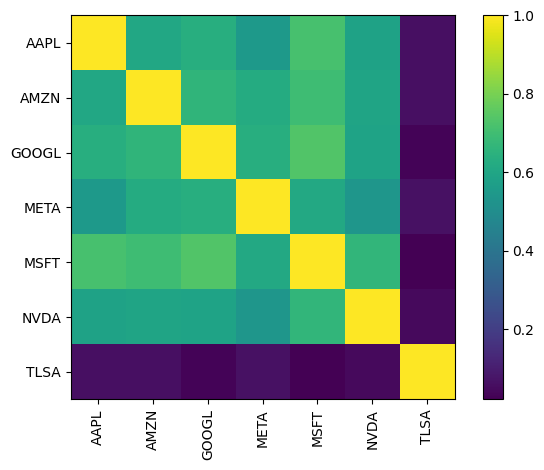

In [74]:
plotting.plot_covariance(cov_matrix, plot_correlation=True)

In [75]:
bl = BlackLittermanModel(
    cov_matrix,
    absolute_views=views,
    pi=market_prior
)

bl_returns = bl.bl_returns()
ef = EfficientFrontier(bl_returns, cov_matrix)
weights = ef.max_sharpe()

bl_weights = pd.DataFrame(
    list(weights.items()), 
    columns=["symbol", "weight"]
).set_index("symbol")

performance = ef.portfolio_performance(verbose=True)

Expected annual return: 18.1%
Annual volatility: 28.9%
Sharpe Ratio: 0.63


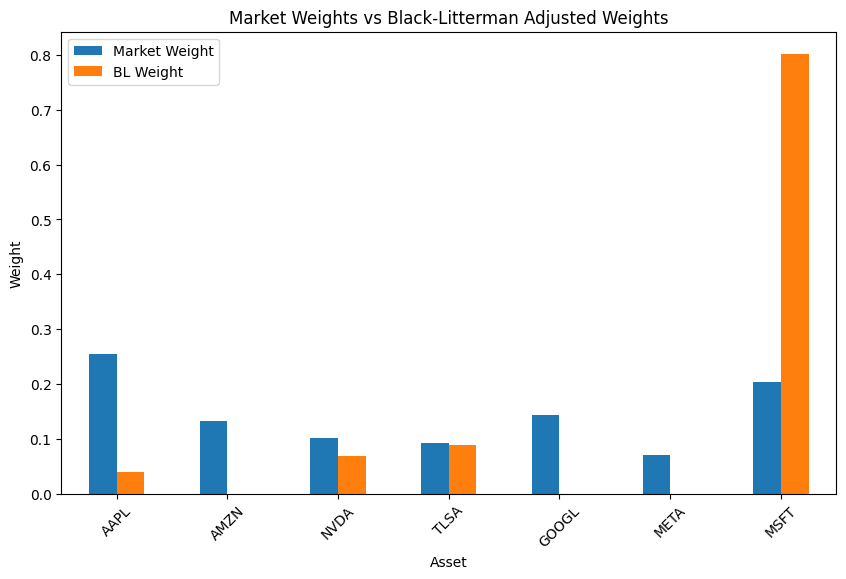

In [76]:
market_weights = {symbol: mcaps[symbol] / sum(mcaps.values()) for symbol in mcaps}


market_weights_df = pd.DataFrame.from_dict(market_weights, orient='index', columns=['Market Weight'])
bl_weights_df = bl_weights.rename(columns={'weight': 'BL Weight'})

weights_df = market_weights_df.join(bl_weights_df)


weights_df.plot(kind='bar', figsize=(10, 6))
plt.title('Market Weights vs Black-Litterman Adjusted Weights')
plt.ylabel('Weight')
plt.xlabel('Asset')
plt.xticks(rotation=45)
plt.show()

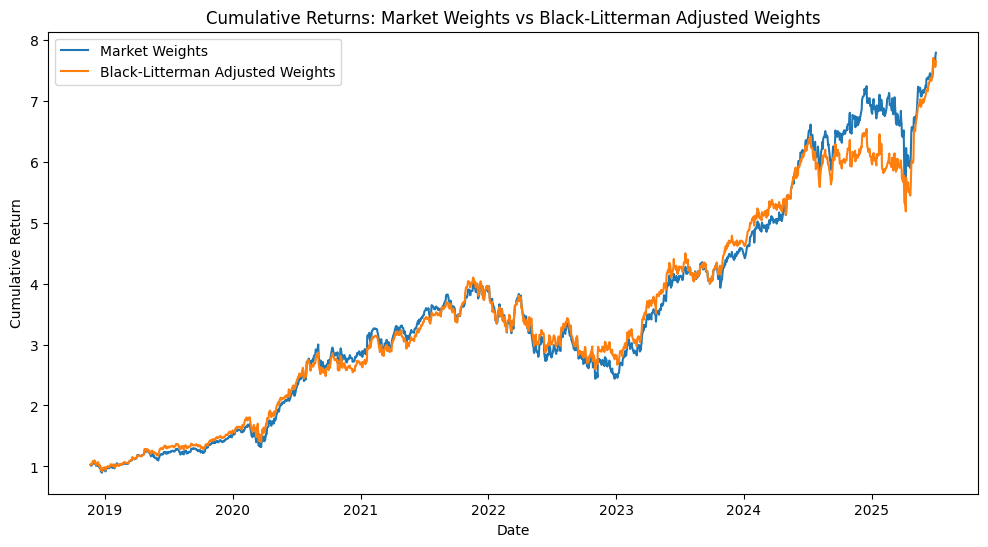

In [77]:

market_cumulative_returns = (prices.pct_change().dot(pd.Series(market_weights)) + 1).cumprod()


bl_cumulative_returns = (prices.pct_change().dot(bl_weights['weight']) + 1).cumprod()


plt.figure(figsize=(12, 6))
plt.plot(market_cumulative_returns, label='Market Weights')
plt.plot(bl_cumulative_returns, label='Black-Litterman Adjusted Weights')
plt.title('Cumulative Returns: Market Weights vs Black-Litterman Adjusted Weights')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()